We process the MAT files to NPY files. In addition, heavy data augmentation is performed.

In [1]:
import time
import os.path as path

import numpy as np

from imgaug import augmenters as iaa
from bunch import Bunch

import matplotlib.pyplot as plt

patch_size = 128

data_dir = 'NPY_FILES'
use_deconv = 'D_P_'

if use_deconv:
    data_dir = use_deconv + data_dir

cdir = '.'
nb_source_img = 2


In [2]:
def get_stride_points(img_size=512, skip=64, stride=16, patch_size=128):
    left = [i for i in range(skip, img_size - skip - patch_size, stride)]
    top = [i for i in range(skip, img_size - skip - patch_size,  stride)]
    return top, left

In [3]:
class ImageAugmentor:
    def __init__(self, images, mode='SIMPLE', labels=None, end_to_end=True):
        self._source_images = images
        self._source_labels = labels
        self._mode = mode
#         self._result_images = [self._source_images.copy()]
#         self._result_labels = [self._source_labels.copy()]
        self._result_images = []
        self._result_labels = []
        self._end_to_end = end_to_end

    def generate(self):
        if self._mode == 'SIMPLE':
            self._geometry_augment()
        else:
            raise NotImplementedError

        if self._end_to_end:
            return np.vstack(self._result_images), np.vstack(
                self._result_labels)
        else:
            return self._result_images, self._result_labels

    def _geometry_augment(self, dropout_prob=0.15):
        # rotation
        rot_augs = [iaa.Affine(rotate=(deg)) for deg in range(0, 90, 15)]
        for aug in rot_augs:
            self._result_images.append(aug.augment_images(self._source_images))
            self._result_labels.append(aug.augment_images(self._source_labels))

        self._source_images = np.vstack(self._result_images.copy())
        self._source_labels = np.vstack(self._result_labels.copy())

        # for those need to modify the mask as well
        flip_lr = iaa.Fliplr(1)
        flip_ud = iaa.Flipud(1)
        flip_lrud = iaa.Sequential([flip_lr, flip_ud])
        mask_modified_augs = [flip_lr, flip_ud, flip_lrud]
        for aug in mask_modified_augs:
            self._result_images.append(aug.augment_images(self._source_images))
            self._result_labels.append(aug.augment_images(self._source_labels))

        # NOTE: directly convert all images to whole black without modify the mask
        # This is caused by the `imgaug` implementation
        # But we actually got benefited... by super strong regularization
        dropout = iaa.Dropout(p=dropout_prob)
        mask_no_modified_augs = [dropout]
        length = len(self._result_images)
        for aug in mask_no_modified_augs:
            for grp_idx in range(length):
                self._result_images.append(
                    aug.augment_images(
                        np.array(
                            (self._result_images[grp_idx])).astype(np.uint8)))
                self._result_labels.append(self._result_labels[grp_idx])

In [4]:
def shuffle_lists(listx, listy):
    xy = list(zip(listx, listy))
    np.random.shuffle(xy)
    final_x, final_y = zip(*xy)
    return list(final_x), list(final_y)
                    

In [5]:
class IVUSDataGenerator:
    def __init__(self, config):
        self.config = config
        img_size = config.state_size[0]
        target = config.target.lower()
        self.input_batches = []
        self.mask_batches = []

        # load data here
        print('Load data for the {} model...'.format(config.target))
        self.input = np.load(
            path.join(path.abspath(cdir), data_dir, 'raw_train_data_512.npy'))[:19]
        self.y = np.expand_dims(
            np.load(
                path.join(
                    path.abspath(cdir), data_dir,
                    'raw_train_{}_labels_512.npy'.format(target))), -1)[:19]

        print(self.input.shape)
        print(self.y.shape)

        self.test_input = np.expand_dims(
            np.load(
                path.join(path.abspath(cdir), data_dir, 'test_data_512.npy')),
            -1)
        self.test_y = np.expand_dims(
            np.load(
                path.join(
                    path.abspath(cdir), data_dir,
                    'test_{}_labels_512.npy'.format(target))).astype(np.uint8),
            -1)

        print(self.test_input.shape)
        print(self.test_y.shape)
        
    def next_batch(self, batch_size=10):
        if len(self.input_batches):
            print('Use exisiting batch')
            print('Batches left:', len(self.input_batches))
            input_batch = self.input_batches.pop()
            input_y = self.mask_batches.pop()
            idx = np.random.choice(input_batch.shape[0], batch_size, replace=False)
            print(idx)
            return input_batch[idx], input_y[idx]
        else:
            print('No storage')
            print('Select', nb_source_img, 'source images...')
            idx = np.random.choice(self.input.shape[0], nb_source_img, replace=False)
            aug = ImageAugmentor(self.input[idx], mode='SIMPLE', labels=self.y[idx], end_to_end=True)
            aug_x, aug_y = aug.generate()
            print('Obtain', aug_x.shape[0], 'images')
            aug_x = aug_x[:aug_x.shape[0] // 10 * 6]  # select the first 1/2
            self.check = aug_x.copy()
            aug_y = aug_y[:aug_y.shape[0] // 10 * 6]  # the second 1/2 are all black images
            print('Obtain', aug_x.shape[0], 'iamges')
            # split by a stride of 32
            count = 0
            while count < batch_size:
                top, left = get_stride_points(stride=32)
                # every augmented image, we build a batch from it
                for i in range(aug_x.shape[0]):
                    final_x = []
                    final_y = []
                    for t in top:
                        for l in left:            
                            y_crop = aug_y[i][t:t + patch_size, l:l + patch_size]
                            if y_crop.any():
                                count += 1
                                x_crop = aug_x[i][t:t + patch_size, l:l + patch_size]
                                final_x.append(x_crop)
                                final_y.append(y_crop)
                            else:
                                continue
                    # TODO: shuffle
                    final_x, final_y = shuffle_lists(final_x, final_y)
                    
                    self.input_batches.append(np.array(final_x))
                    self.mask_batches.append(np.array(final_y))
                
            self.input_batches, self.mask_batches = shuffle_lists(self.input_batches, self.mask_batches)
            print('Generated batches -->', len(self.input_batches))
            print('Every batch contains -->', self.input_batches[0].shape)
                    
            # provide one group of result
            input_batch = self.input_batches.pop()
            input_y = self.mask_batches.pop()
            idx = np.random.choice(input_batch.shape[0], batch_size, replace=False)
            return input_batch[idx], input_y[idx]

    def get_test_subsets(self, subset_size):
        test_set_size = self.test_input.shape[0]
        test_subsets = [(self.test_input[i:i + subset_size],
                         self.test_y[i:i + subset_size])
                        for i in range(0, test_set_size, subset_size)]
        return test_subsets

In [6]:
config = {
    "activation": "prelu", 
    "batch_size": 10,
    "is_training": 1,
    "learning_rate": 0.0001,
    "max_to_keep": 1,
    "num_epochs": 192,
    "num_iter_per_epoch": 18,
    "pooling": "max",
    "run": 1,
    "state_size": [128, 128, 1],
    "target": "Lumen",
    "version": 1,
    "exp_name": "V1-Journal-ImageSize128-Epoch192-Iter18-LR0.0001-BS10-prelu-max-Lumen-1"
}

config = Bunch(config)

In [7]:
dg = IVUSDataGenerator(config)

Load data for the Lumen model...
(19, 512, 512)
(19, 512, 512, 1)
(58, 512, 512, 1)
(58, 512, 512, 1)


In [8]:
x, y = dg.next_batch(batch_size=10)
x.shape, y.shape

No storage
Select 2 source images...
Obtain 96 images
Obtain 54 iamges
Generated batches --> 54
Every batch contains --> (64, 128, 128)


((10, 128, 128), (10, 128, 128, 1))

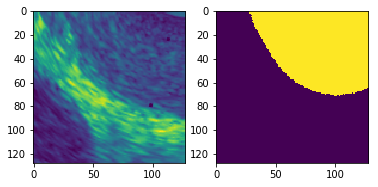

In [9]:
plt.subplot(121)
plt.imshow(x[0])
plt.subplot(122)
plt.imshow(y[0].reshape(128, 128))

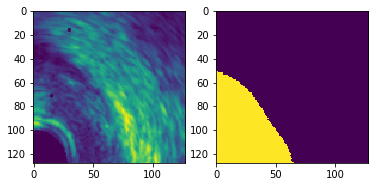

In [10]:
plt.subplot(121)
plt.imshow(x[1])
plt.subplot(122)
plt.imshow(y[1].reshape(128, 128))

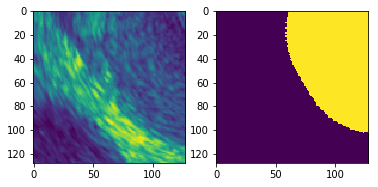

In [11]:
plt.subplot(121)
plt.imshow(x[2])
plt.subplot(122)
plt.imshow(y[2].reshape(128, 128))

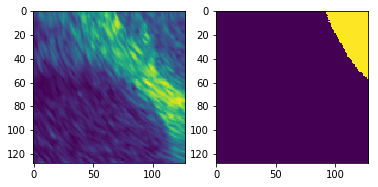

In [12]:
plt.subplot(121)
plt.imshow(x[4])
plt.subplot(122)
plt.imshow(y[4].reshape(128, 128))